In [2]:
"""
Example workflow demonstrating how to use the improved GraphBuilder
for planar graph classification with 11-14 nodes
"""

import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data, DataLoader
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import pandas as pd
import ast

In [3]:
# Defining a simple GNN model. 
class PlanarGraphGNN(torch.nn.Module):
    def __init__(self, num_features, hidden_dim = 32 , num_classes=2, dropout = 0.2):
        super().__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.norm1 = GraphNorm(hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.norm2 = GraphNorm(hidden_dim,hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.norm3 = GraphNorm(hidden_dim)
        self.lin = torch.nn.Linear(hidden_dim, num_classes)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        batch = data.batch # For multiple graphs in a batch
        x = F.relu(self.norm1(self.conv1(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.norm2(self.conv2(x, edge_index)))
        x = self.dropout(x)
        x = F.relu(self.norm3(self.conv3(x, edge_index)))
        x = self.dropout(x)
        x = global_mean_pool(x, batch)
        return self.lin(x)

In [2]:
class PlanarGraphGNN(torch.nn.Module):
    """Simple GNN for planar graph classification"""
    
    def __init__(self, num_features, hidden_dim=32, num_classes=2, dropout=0.2):
        super(PlanarGraphGNN, self).__init__()
        
        # Use shallow architecture for small graphs
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim//2)
        
        self.dropout = dropout
        self.classifier = torch.nn.Linear(hidden_dim//2, num_classes)
        
    def forward(self, x, edge_index, batch=None):
        # First GCN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Second GCN layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        
        # Global pooling
        if batch is None:
            x = global_mean_pool(x, torch.zeros(x.size(0), dtype=torch.long))
        else:
            x = global_mean_pool(x, batch)
        
        # Classification
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


In [ ]:
def create_graph_dataset(graphs_data: List[Tuple[List, int]], 
                        feature_config: Dict) -> List[Data]:
    """
    Create dataset from graph data using improved GraphBuilder
    
    Args:
        graphs_data: List of (edges, label) tuples
        feature_config: Configuration for GraphBuilder
        
    Returns:
        List of PyTorch Geometric Data objects
    """
    from GraphBuilder_with_features_Claude import GraphBuilder
    
    dataset = []
    all_features = []
    
    # First pass: collect all features for normalization
    print("Extracting features...")
    for edges, label in graphs_data:
        builder = GraphBuilder(
            solid_edges=edges,
            coeff=label,
            **feature_config
        )
        data = builder.build()
        dataset.append(data)
        all_features.append(data.x.numpy())
    
    # Compute normalization statistics
    all_features = np.vstack(all_features)
    scaler = StandardScaler()
    scaler.fit(all_features)
    
    # Second pass: normalize features
    print("Normalizing features...")
    for i, data in enumerate(dataset):
        # Get the starting index for this graph's features
        start_idx = sum(d.num_nodes for d in dataset[:i])
        end_idx = start_idx + data.num_nodes
        
        # Normalize
        normalized_features = scaler.transform(data.x.numpy())
        data.x = torch.FloatTensor(normalized_features)
    
    print(f"Created dataset with {len(dataset)} graphs")
    print(f"Feature dimensions: {dataset[0].x.shape[1]}")
    print(f"Feature names: {dataset[0].feature_names}")
    
    return dataset, scaler


def evaluate_feature_importance(model, dataset, feature_names):
    """Evaluate which features are most important for the model"""
    
    model.eval()
    feature_gradients = []
    
    with torch.enable_grad():
        for data in dataset:
            data.x.requires_grad = True
            
            # Forward pass
            out = model(data.x, data.edge_index)
            loss = F.nll_loss(out, data.y.unsqueeze(0))
            
            # Backward pass
            loss.backward()
            
            # Store gradients
            grad = data.x.grad.abs().mean(dim=0)
            feature_gradients.append(grad.numpy())
    
    # Average gradients across all graphs
    avg_gradients = np.mean(feature_gradients, axis=0)
    
    # Sort features by importance
    importance_scores = list(zip(feature_names, avg_gradients))
    importance_scores.sort(key=lambda x: x[1], reverse=True)
    
    return importance_scores


def train_and_evaluate(dataset, feature_config, num_epochs=100, k_folds=5):
    """Train and evaluate model using k-fold cross validation"""
    
    # Prepare for k-fold cross validation
    labels = [data.y.item() for data in dataset]
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    fold_accuracies = []
    fold_feature_importance = []
    
    for fold, (train_idx, test_idx) in enumerate(skf.split(range(len(dataset)), labels)):
        print(f"\nFold {fold + 1}/{k_folds}")
        
        # Split dataset
        train_dataset = [dataset[i] for i in train_idx]
        test_dataset = [dataset[i] for i in test_idx]
        
        # Create data loaders
        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
        
        # Initialize model
        num_features = dataset[0].x.shape[1]
        model = PlanarGraphGNN(num_features, hidden_dim=32, num_classes=2)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        
        # Training
        model.train()
        for epoch in range(num_epochs):
            for batch in train_loader:
                optimizer.zero_grad()
                out = model(batch.x, batch.edge_index, batch.batch)
                loss = F.nll_loss(out, batch.y)
                loss.backward()
                optimizer.step()
            
            if (epoch + 1) % 20 == 0:
                print(f"  Epoch {epoch + 1}/{num_epochs}, Loss: {loss:.4f}")
        
        # Evaluation
        model.eval()
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in test_loader:
                out = model(batch.x, batch.edge_index, batch.batch)
                pred = out.argmax(dim=1)
                correct += pred.eq(batch.y).sum().item()
                total += batch.y.size(0)
        
        accuracy = correct / total
        fold_accuracies.append(accuracy)
        print(f"  Test Accuracy: {accuracy:.4f}")
        
        # Feature importance for this fold
        if hasattr(dataset[0], 'feature_names'):
            importance = evaluate_feature_importance(model, test_dataset, 
                                                   dataset[0].feature_names)
            fold_feature_importance.append(importance)
    
    # Summary
    print(f"\n{'='*50}")
    print(f"Cross-validation Results:")
    print(f"  Mean Accuracy: {np.mean(fold_accuracies):.4f} ± {np.std(fold_accuracies):.4f}")
    print(f"  All Folds: {fold_accuracies}")
    
    # Average feature importance across folds
    if fold_feature_importance:
        avg_importance = {}
        for feat_name in dataset[0].feature_names:
            scores = [dict(fold)[feat_name] for fold in fold_feature_importance]
            avg_importance[feat_name] = np.mean(scores)
        
        print(f"\nTop 10 Most Important Features:")
        sorted_importance = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
        for i, (feat, score) in enumerate(sorted_importance[:10]):
            print(f"  {i+1}. {feat:25s}: {score:.4f}")
    
    return fold_accuracies, avg_importance


def compare_feature_sets(graphs_data):
    """Compare different feature configurations"""
    
    feature_configs = {
        'Minimal': {
            'selected_features': ['basic', 'face'],
            'laplacian_pe_k': 0
        },
        'Planar-focused': {
            'selected_features': ['basic', 'face', 'dual'],
            'laplacian_pe_k': 2
        },
        'Balanced': {
            'selected_features': ['basic', 'face', 'spectral_node', 'centrality'],
            'laplacian_pe_k': 3
        },
        'Full': {
            'selected_features': ['basic', 'face', 'spectral_node', 'dual', 'centrality'],
            'laplacian_pe_k': 4
        }
    }
    
    results = {}
    
    for config_name, config in feature_configs.items():
        print(f"\n{'='*60}")
        print(f"Testing configuration: {config_name}")
        print(f"{'='*60}")
        
        # Create dataset with this configuration
        dataset, scaler = create_graph_dataset(graphs_data, config)
        
        # Train and evaluate
        accuracies, importance = train_and_evaluate(dataset, config, num_epochs=50)
        
        results[config_name] = {
            'accuracies': accuracies,
            'mean_accuracy': np.mean(accuracies),
            'std_accuracy': np.std(accuracies),
            'num_features': dataset[0].x.shape[1],
            'importance': importance
        }
    
    # Plot comparison
    plt.figure(figsize=(10, 6))
    
    configs = list(results.keys())
    means = [results[c]['mean_accuracy'] for c in configs]
    stds = [results[c]['std_accuracy'] for c in configs]
    num_features = [results[c]['num_features'] for c in configs]
    
    x = np.arange(len(configs))
    
    plt.subplot(1, 2, 1)
    plt.bar(x, means, yerr=stds, capsize=10)
    plt.xlabel('Configuration')
    plt.ylabel('Accuracy')
    plt.title('Model Performance by Feature Configuration')
    plt.xticks(x, configs, rotation=45)
    
    plt.subplot(1, 2, 2)
    plt.scatter(num_features, means, s=100)
    plt.errorbar(num_features, means, yerr=stds, fmt='none', capsize=5)
    for i, config in enumerate(configs):
        plt.annotate(config, (num_features[i], means[i]), 
                    xytext=(5, 5), textcoords='offset points')
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Feature Dimensionality')
    
    plt.tight_layout()
    plt.show()
    
    return results



In [5]:

# Generate example planar graphs (you would use your actual data here)
def generate_example_graphs(n_graphs=100):
    """Generate example planar graphs for demonstration"""
    graphs_data = []
    
    for i in range(n_graphs):
        # Create variations of planar graphs with 11-14 nodes
        n_nodes = np.random.randint(11, 15)
        
        if i % 2 == 0:
            # Type 1: Grid-like structure (label 0)
            edges = []
            nodes = [f'N{j}' for j in range(n_nodes)]
            
            # Create grid structure
            grid_size = int(np.sqrt(n_nodes))
            for row in range(grid_size):
                for col in range(grid_size - 1):
                    idx = row * grid_size + col
                    if idx < n_nodes - 1:
                        edges.append((nodes[idx], nodes[idx + 1]))
            
            for col in range(grid_size):
                for row in range(grid_size - 1):
                    idx = row * grid_size + col
                    if idx + grid_size < n_nodes:
                        edges.append((nodes[idx], nodes[idx + grid_size]))
            
            label = 0
        else:
            # Type 2: Wheel-like structure (label 1)
            edges = []
            nodes = [f'N{j}' for j in range(n_nodes)]
            center = nodes[0]
            
            # Connect center to all others
            for i in range(1, min(n_nodes, 8)):
                edges.append((center, nodes[i]))
            
            # Connect rim
            for i in range(1, min(n_nodes - 1, 7)):
                edges.append((nodes[i], nodes[i + 1]))
            edges.append((nodes[min(n_nodes - 1, 7)], nodes[1]))
            
            # Add some additional edges
            if n_nodes > 8:
                for i in range(8, n_nodes):
                    edges.append((nodes[i], nodes[i % 7 + 1]))
            
            label = 1
        
        graphs_data.append((edges, label))
    
    return graphs_data


In [ ]:
# Generate dataset
p#rint("Generating example planar graphs...")
#graphs_data = generate_example_graphs(100)

Generating example planar graphs...


In [22]:
loop=8
# Create the edge and y lists from the csv files\
edges=[]
y=[]
for i in range(loop,loop+1):
    filename = f'../Graph_Edge_Data/den_graph_data_{loop}.csv'
    df = pd.read_csv(filename)
    edges += df['EDGES'].tolist()
    y += df['COEFFICIENTS'].tolist()
edges = [ast.literal_eval(e) for e in edges]    
graphs_data = list(zip(edges, y))


Testing configuration: Minimal
Extracting features...
Normalizing features...
Created dataset with 1432 graphs
Feature dimensions: 5
Feature names: ['degree', 'num_faces', 'avg_face_size', 'max_face_size', 'face_size_variance']

Fold 1/5


/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch 20/50, Loss: 0.6361
  Epoch 40/50, Loss: 0.6010
  Test Accuracy: 0.7178

Fold 2/5
  Epoch 20/50, Loss: 0.5283
  Epoch 40/50, Loss: 0.5776
  Test Accuracy: 0.6551

Fold 3/5
  Epoch 20/50, Loss: 0.4760
  Epoch 40/50, Loss: 0.5573
  Test Accuracy: 0.6853

Fold 4/5
  Epoch 20/50, Loss: 0.4972
  Epoch 40/50, Loss: 0.5268
  Test Accuracy: 0.6888

Fold 5/5
  Epoch 20/50, Loss: 0.5585
  Epoch 40/50, Loss: 0.7074
  Test Accuracy: 0.6678

Cross-validation Results:
  Mean Accuracy: 0.6830 ± 0.0213
  All Folds: [0.7177700348432056, 0.6550522648083623, 0.6853146853146853, 0.6888111888111889, 0.6678321678321678]

Top 10 Most Important Features:
  1. max_face_size            : 0.2484
  2. face_size_variance       : 0.1337
  3. degree                   : 0.1025
  4. avg_face_size            : 0.1024
  5. num_faces                : 0.0387

Testing configuration: Planar-focused
Extracting features...
Normalizing features...
Created dataset with 1432 graphs
Feature dimensions: 10
Feature names: [

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch 20/50, Loss: 0.4860
  Epoch 40/50, Loss: 0.4528
  Test Accuracy: 0.7422

Fold 2/5
  Epoch 20/50, Loss: 0.5917
  Epoch 40/50, Loss: 0.2898
  Test Accuracy: 0.7108

Fold 3/5
  Epoch 20/50, Loss: 0.6058
  Epoch 40/50, Loss: 0.5204
  Test Accuracy: 0.7343

Fold 4/5
  Epoch 20/50, Loss: 0.7003
  Epoch 40/50, Loss: 0.4700
  Test Accuracy: 0.6853

Fold 5/5
  Epoch 20/50, Loss: 0.3939
  Epoch 40/50, Loss: 0.5088
  Test Accuracy: 0.7133

Cross-validation Results:
  Mean Accuracy: 0.7172 ± 0.0199
  All Folds: [0.7421602787456446, 0.710801393728223, 0.7342657342657343, 0.6853146853146853, 0.7132867132867133]

Top 10 Most Important Features:
  1. dual_clustering          : 0.2090
  2. degree                   : 0.1931
  3. max_face_size            : 0.1925
  4. dual_betweenness         : 0.1865
  5. dual_degree              : 0.1576
  6. avg_face_size            : 0.1111
  7. face_edge_ratio          : 0.0686
  8. dual_degree_ratio        : 0.0495
  9. face_size_variance       : 0.0430
  1

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch 20/50, Loss: 0.6240
  Epoch 40/50, Loss: 0.6778
  Test Accuracy: 0.7700

Fold 2/5
  Epoch 20/50, Loss: 0.3967
  Epoch 40/50, Loss: 0.5114
  Test Accuracy: 0.7456

Fold 3/5
  Epoch 20/50, Loss: 0.3896
  Epoch 40/50, Loss: 0.4831
  Test Accuracy: 0.7552

Fold 4/5
  Epoch 20/50, Loss: 0.4222
  Epoch 40/50, Loss: 0.5951
  Test Accuracy: 0.7692

Fold 5/5
  Epoch 20/50, Loss: 0.5409
  Epoch 40/50, Loss: 0.3567
  Test Accuracy: 0.7692

Cross-validation Results:
  Mean Accuracy: 0.7619 ± 0.0098
  All Folds: [0.7700348432055749, 0.7456445993031359, 0.7552447552447552, 0.7692307692307693, 0.7692307692307693]

Top 10 Most Important Features:
  1. betweenness_centrality   : 0.2320
  2. max_face_size            : 0.1398
  3. clustering_coefficient   : 0.1383
  4. avg_face_size            : 0.1093
  5. eigenvector_centrality   : 0.0690
  6. closeness_centrality     : 0.0656
  7. degree                   : 0.0567
  8. pagerank                 : 0.0414
  9. fiedler_vector           : 0.0405
  

/home/gabriele/Documents/GitHub/ML-correlator/.venv/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


  Epoch 20/50, Loss: 0.5107
  Epoch 40/50, Loss: 0.3491
  Test Accuracy: 0.7700

Fold 2/5
  Epoch 20/50, Loss: 0.3598
  Epoch 40/50, Loss: 0.5877
  Test Accuracy: 0.7596

Fold 3/5
  Epoch 20/50, Loss: 0.5557
  Epoch 40/50, Loss: 0.5228
  Test Accuracy: 0.7517

Fold 4/5
  Epoch 20/50, Loss: 0.3922
  Epoch 40/50, Loss: 0.4520
  Test Accuracy: 0.7832

Fold 5/5
  Epoch 20/50, Loss: 0.4990
  Epoch 40/50, Loss: 0.3937
  Test Accuracy: 0.7552

Cross-validation Results:
  Mean Accuracy: 0.7640 ± 0.0114
  All Folds: [0.7700348432055749, 0.759581881533101, 0.7517482517482518, 0.7832167832167832, 0.7552447552447552]

Top 10 Most Important Features:
  1. betweenness_centrality   : 0.1786
  2. max_face_size            : 0.1159
  3. avg_face_size            : 0.1042
  4. clustering_coefficient   : 0.0817
  5. closeness_centrality     : 0.0807
  6. dual_clustering          : 0.0800
  7. dual_betweenness         : 0.0715
  8. dual_degree_ratio        : 0.0491
  9. eigenvector_centrality   : 0.0486
  1

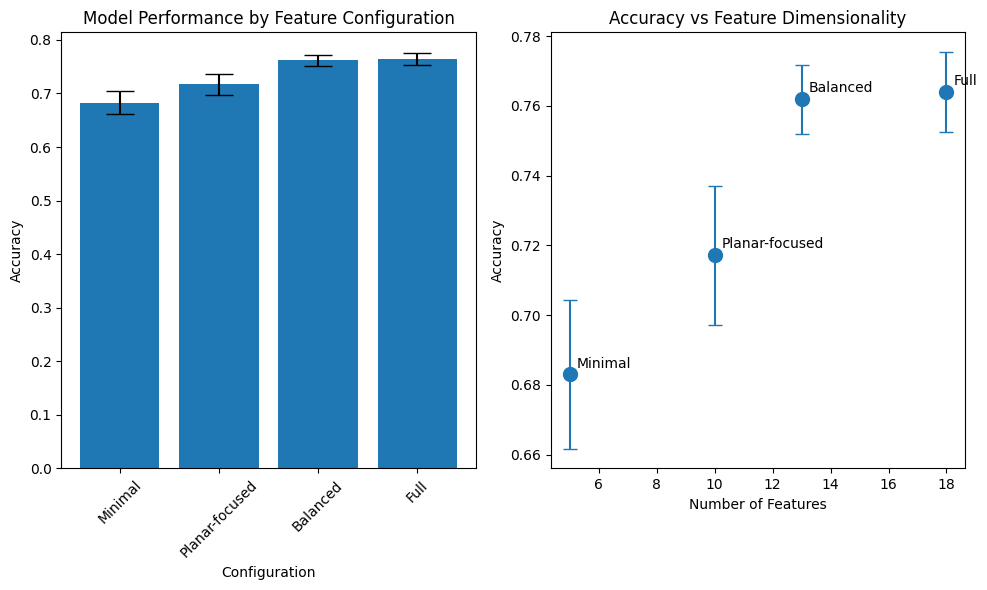

In [26]:
# Compare different feature configurations
results = compare_feature_sets(graphs_data)

In [24]:
# Print summary
print("\n" + "="*60)
print("SUMMARY: Feature Configuration Comparison")
print("="*60)

for config, res in results.items():
    print(f"\n{config}:")
    print(f"  Features: {res['num_features']}")
    print(f"  Accuracy: {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")


SUMMARY: Feature Configuration Comparison

Minimal:
  Features: 5
  Accuracy: 0.6836 ± 0.0247

Planar-focused:
  Features: 10
  Accuracy: 0.7479 ± 0.0072

Balanced:
  Features: 13
  Accuracy: 0.7814 ± 0.0115

Full:
  Features: 18
  Accuracy: 0.7758 ± 0.0198


In [27]:
# Print summary
print("\n" + "="*60)
print("SUMMARY: Feature Configuration Comparison")
print("="*60)

for config, res in results.items():
    print(f"\n{config}:")
    print(f"  Features: {res['num_features']}")
    print(f"  Accuracy: {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")


SUMMARY: Feature Configuration Comparison

Minimal:
  Features: 5
  Accuracy: 0.6830 ± 0.0213

Planar-focused:
  Features: 10
  Accuracy: 0.7172 ± 0.0199

Balanced:
  Features: 13
  Accuracy: 0.7619 ± 0.0098

Full:
  Features: 18
  Accuracy: 0.7640 ± 0.0114
